## Last Value Estimator that is Scikit-Learn compatible

In [1]:
import xgboost
import sklearn
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model_selection import OptunaCVOptimizer
from quantbullet.model import LastValueEstimator, TypicalHyperparameterRanges
from quantbullet.model_selection import TimeSeriesDailyRollingSplit

# Load the sunspots dataset
sunspots = sm.datasets.sunspots.load_pandas().data

# Create a new feature by shifting the sunspots count
sunspots['lagged_sunspots'] = sunspots['SUNACTIVITY'].shift(1)

# Drop the first row which will have a NaN value in the 'lagged_sunspots' column
sunspots = sunspots.iloc[1:]

# Reset the index and rename the column
sunspots_reset = sunspots.reset_index().rename(columns={'index': 'date'})

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = sunspots_reset[['YEAR', 'date', 'lagged_sunspots']]
y = sunspots_reset['SUNACTIVITY']

## A Simple Backtest

In [3]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

neg_abs_error_last_value = cross_val_score(
    LastValueEstimator(reference_column="date"),
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)

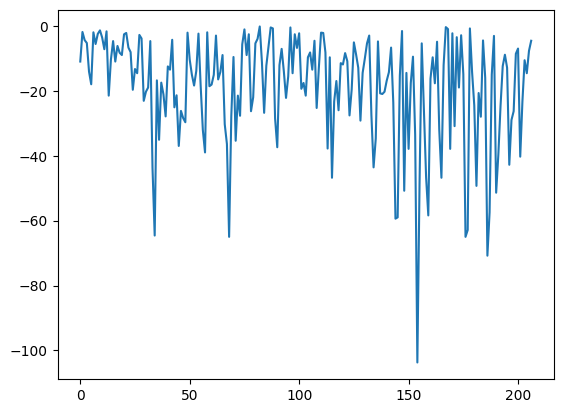

In [4]:
plt.plot(neg_abs_error_last_value)

In [5]:
import numpy as np
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100)
estimator = LastValueEstimator('date')
predictions = np.full(y.shape, np.nan)

# Loop over the splits
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the estimator and make predictions
    estimator.fit(X_train, y_train)
    predictions[test_index] = estimator.predict(X_test)

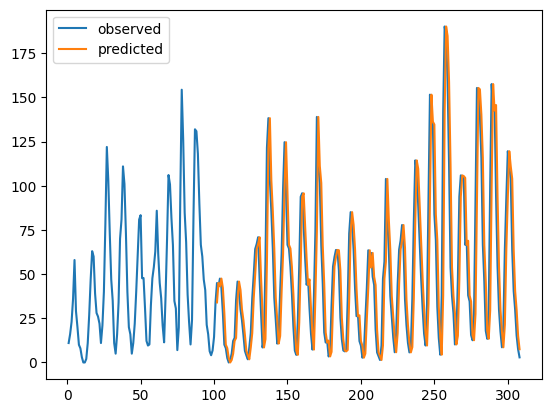

In [6]:
plt.plot(sunspots_reset['date'], sunspots_reset['SUNACTIVITY'], label='observed')
plt.plot(sunspots_reset['date'], predictions, label='predicted')
plt.legend()

## XGBoost Model

In [22]:
tuning_params = TypicalHyperparameterRanges.xgboost

In [23]:
tuning_params['max_depth'].insert(0, 1)
tuning_params['n_estimators'].insert(0, 2)

In [24]:
ts_split = list(TimeSeriesDailyRollingSplit(min_train_size=100).split(X))
optimizer = OptunaCVOptimizer(
    X=X,
    y=y,
    model=xgboost.XGBRegressor(random_state=42),
    cv=ts_split,
    objective="reg:absoluteerror",
    scoring="neg_mean_absolute_error",
)

In [25]:
optimizer.optimize(
    fixed_params={},
    tuning_params=tuning_params,
    n_trials=100)

Best trial: 48. Best value: -18.2957: 100%|██████████| 100/100 [09:17<00:00,  5.58s/it]


In [26]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

model = xgboost.XGBRegressor(objective="reg:absoluteerror",
                             random_state=42,
                             **optimizer.best_params)

neg_abs_error = cross_val_score(
    model,
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)
    

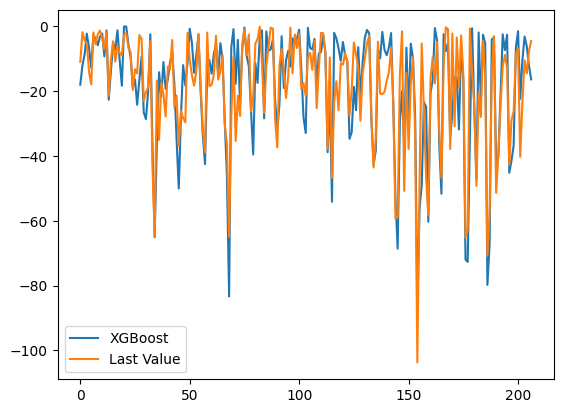

In [27]:
plt.plot(neg_abs_error, label='XGBoost');
plt.plot(neg_abs_error_last_value, label='Last Value');
plt.legend();

In [28]:
np.mean(neg_abs_error), np.mean(neg_abs_error_last_value)

(-18.29570182878614, -18.70193236714976)